In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
import torchvision
import torchvision.transforms as T
import torchvision.models as models
from torchvision.datasets import ImageFolder

In [2]:
#data path
train_path='/kaggle/input/100-bird-species/train/'
test_path='/kaggle/input/100-bird-species/test/'
valid_path='/kaggle/input/100-bird-species/valid/'

In [3]:
#settings
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
mean=[0.485, 0.456, 0.406] #mean of imagenet
std=[0.229, 0.224, 0.225] #std of imagenet
batch_size=64
transforms=T.Compose([
    T.Resize((128,128)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize(mean=mean,std=std)
])

test_transforms=T.Compose([
    T.Resize((128,128)),
    T.ToTensor(),
    T.Normalize(mean=mean,std=std)
])

In [4]:
#dataset
train_dataset=ImageFolder(root=train_path,transform=transforms)
valid_dataset=ImageFolder(root=valid_path,transform=test_transforms)
test_dataset=ImageFolder(root=test_path,transform=test_transforms)
train_dataloader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
valid_dataloader=DataLoader(valid_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
test_dataloader=DataLoader(test_dataset,batch_size=batch_size,shuffle=True,num_workers=2)

print('train_dataset:',len(train_dataset))
print('valid_datset:',len(valid_dataset))
print('test_dataset:',len(test_dataset))

train_dataset: 84635
valid_datset: 2625
test_dataset: 2625


In [5]:
#label list
birds_csv=pd.read_csv('/kaggle/input/100-bird-species/birds.csv')
birds_list_csv=birds_csv[['class id','labels']]
birds_list_df=birds_list_csv.drop_duplicates(ignore_index=True)

birds_list=[]
for i in range(len(birds_list_df)):
    bird_name=birds_list_df['labels'][i]
    birds_list.append(bird_name)
    
print(len(birds_list))

525


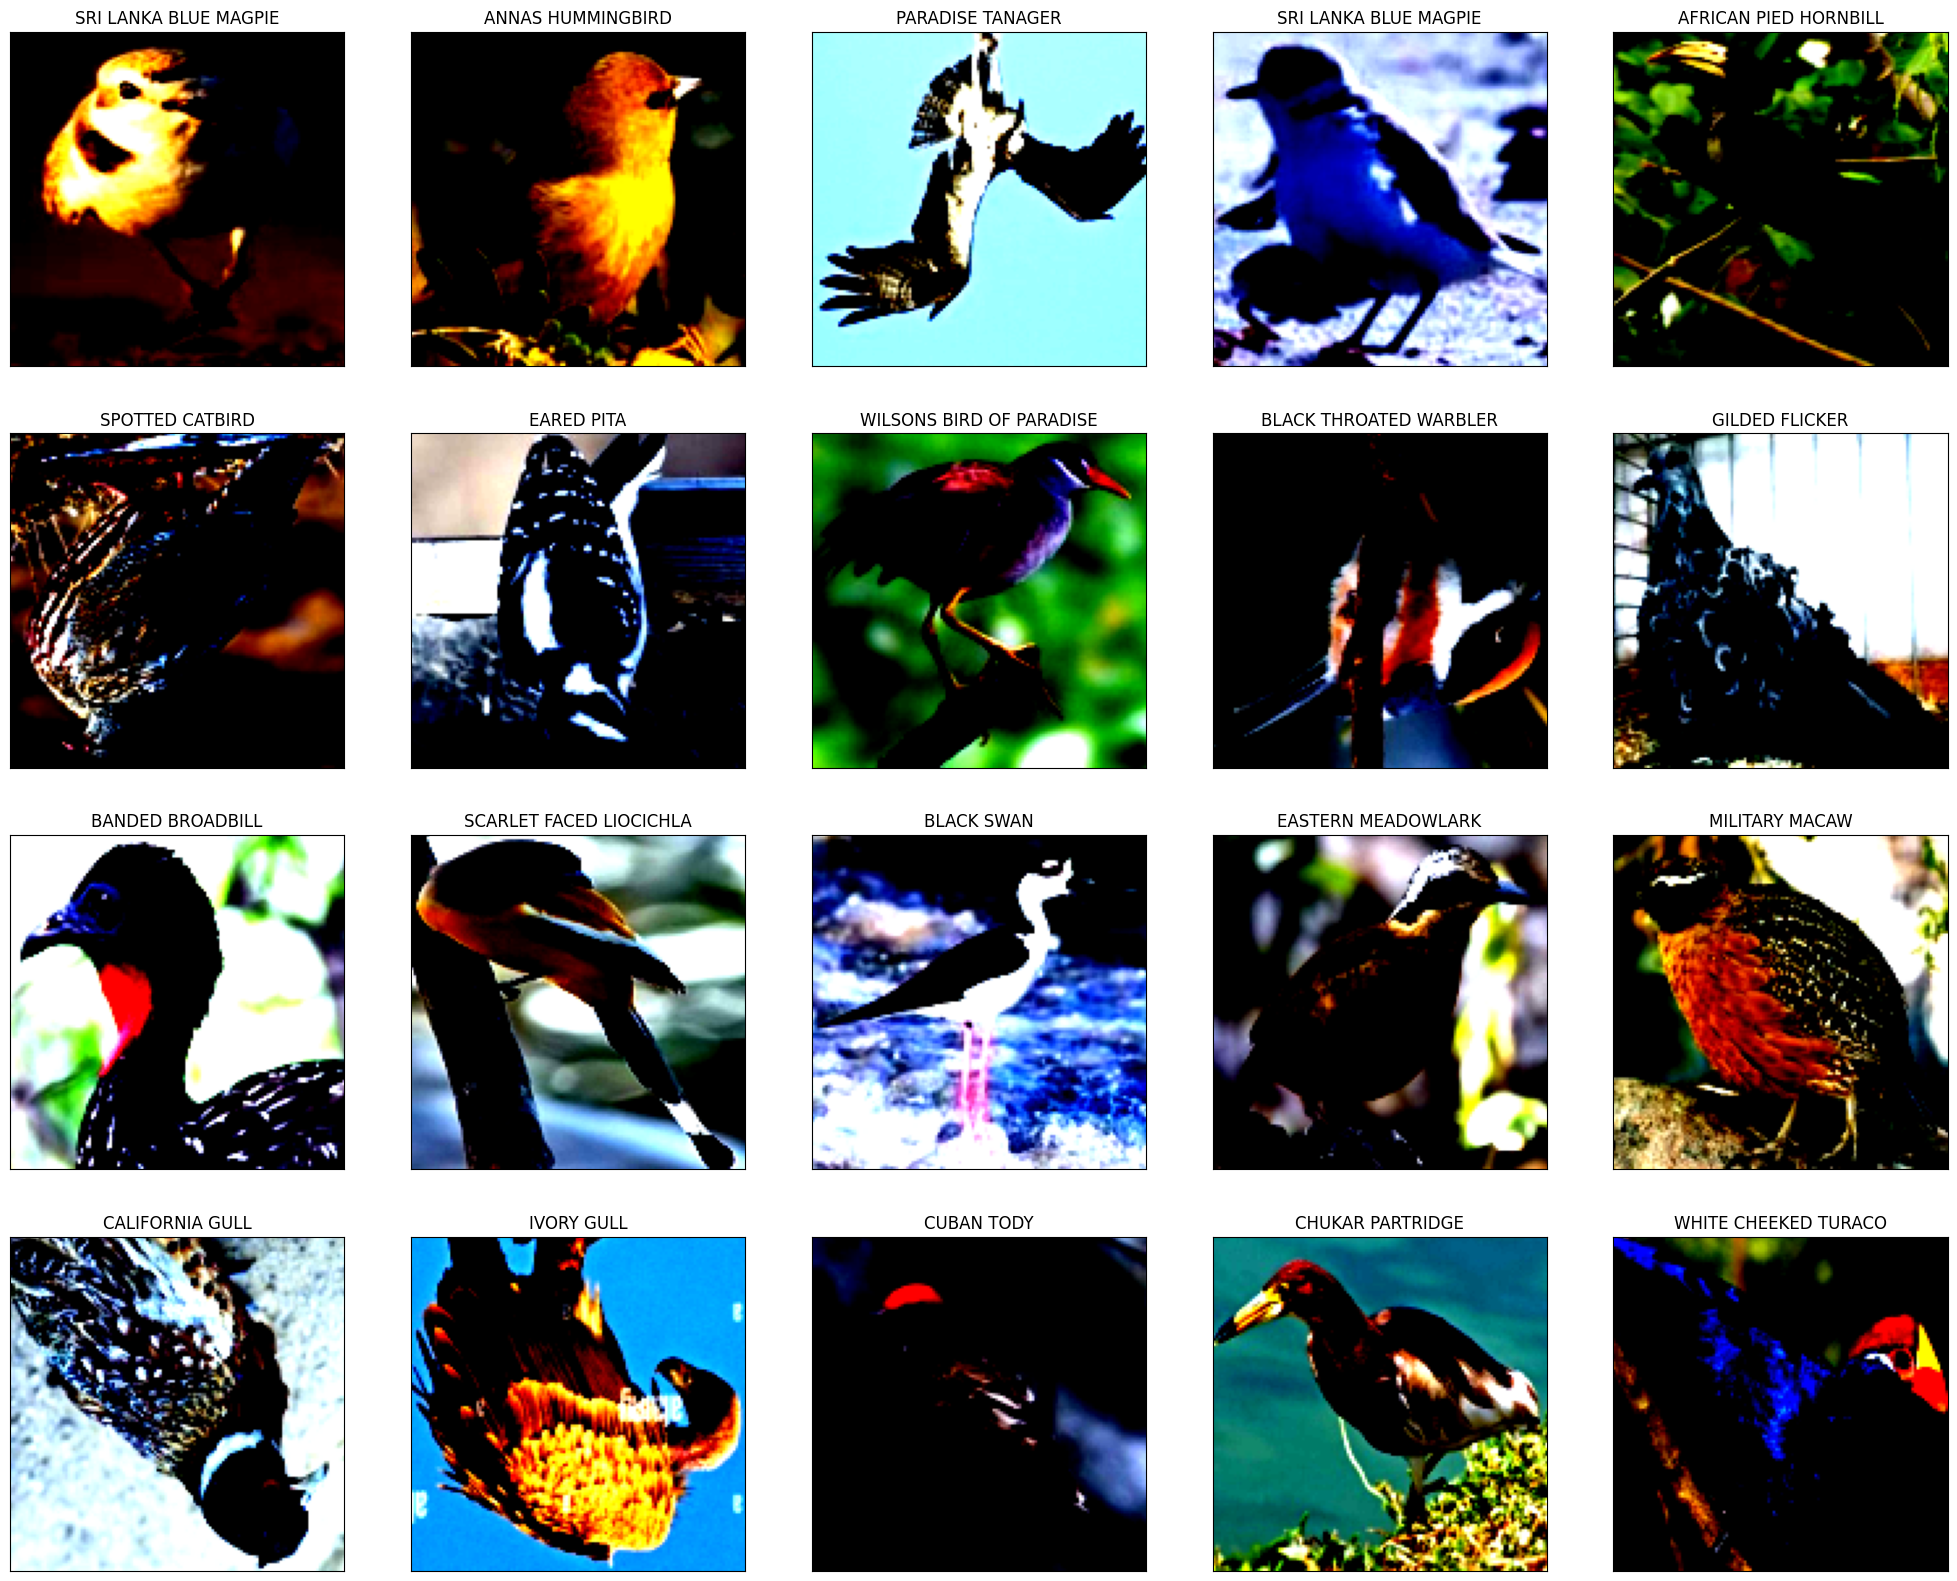

In [6]:
#view image and label
dataiter=iter(train_dataloader)
images,labels=next(dataiter)
images=images.numpy()

fig=plt.figure(figsize=(25,20))
for idx in np.arange(20):
    ax=fig.add_subplot(4,5,idx+1,xticks=[],yticks=[])
    plt.imshow(np.transpose(images[idx],(1,2,0)))
    ax.set_title(birds_list[labels[idx]])

In [7]:
#model
model=models.vgg16(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 158MB/s]  


In [8]:
#fine tuning
n_classes=len(birds_list)
num_f=model.classifier[6].in_features 
model.classifier[6]=nn.Linear(num_f,n_classes)
model.to(device)
print(model) 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
#train and valid
epochs=10
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)
criterion=nn.CrossEntropyLoss()
metrics={'train_loss':[],'valid_loss':[]} 

for epoch in range(epochs):
    train_loss=[]
    valid_loss=[]
    model.train()
    for data in train_dataloader:
        optimizer.zero_grad()
        images,labels=data
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        if len(train_loss)%600==0:
            print('Epoch:',epoch+1)
            print('train_loss:',train_loss[-1])
            
    model.eval()
    with torch.no_grad():
        for data in valid_dataloader:
            images,labels=data
            images=images.to(device)
            labels=labels.to(device)
            outputs=model(images)
            loss=criterion(outputs,labels)
            valid_loss.append(loss.item())
            if len(valid_loss)%40==0:
                print('Epoch:',epoch+1)
                print('valid_loss:',valid_loss[-1])
    
    train_loss_mean=torch.mean(torch.Tensor(train_loss)).item()
    valid_loss_mean=torch.mean(torch.Tensor(valid_loss)).item()
    metrics["train_loss"].append(train_loss_mean)
    metrics["valid_loss"].append(valid_loss_mean)
    print('training_loss:',train_loss_mean, 'validation_loss:',valid_loss_mean)

Epoch: 1
train_loss: 2.2628173828125
Epoch: 1
train_loss: 1.3618972301483154
Epoch: 1
valid_loss: 0.7224485278129578
training_loss: 2.767836332321167 validation_loss: 0.8189516663551331
Epoch: 2
train_loss: 1.0510282516479492
Epoch: 2
train_loss: 0.4826034903526306
Epoch: 2
valid_loss: 0.482794851064682
training_loss: 1.0273797512054443 validation_loss: 0.5205826759338379
Epoch: 3
train_loss: 0.6188037991523743
Epoch: 3
train_loss: 0.6301042437553406
Epoch: 3
valid_loss: 0.379599392414093
training_loss: 0.722790539264679 validation_loss: 0.39662793278694153
Epoch: 4
train_loss: 0.38932183384895325
Epoch: 4
train_loss: 0.7491823434829712
Epoch: 4
valid_loss: 0.5062785744667053
training_loss: 0.5692498683929443 validation_loss: 0.351334810256958
Epoch: 5
train_loss: 0.5426590442657471
Epoch: 5
train_loss: 0.4371275007724762
Epoch: 5
valid_loss: 0.3290269672870636
training_loss: 0.47717124223709106 validation_loss: 0.35029885172843933
Epoch: 6
train_loss: 0.6746364235877991
Epoch: 6
train

<Axes: >

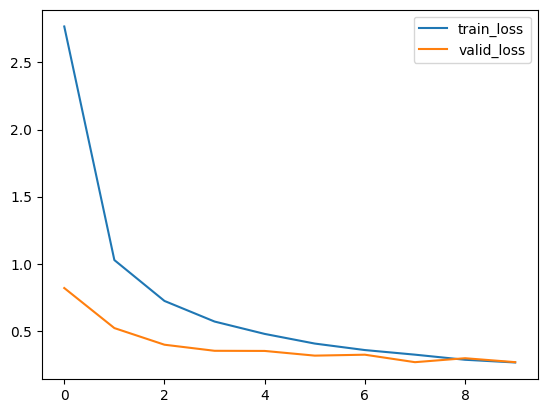

In [10]:
pd.DataFrame(metrics).plot()

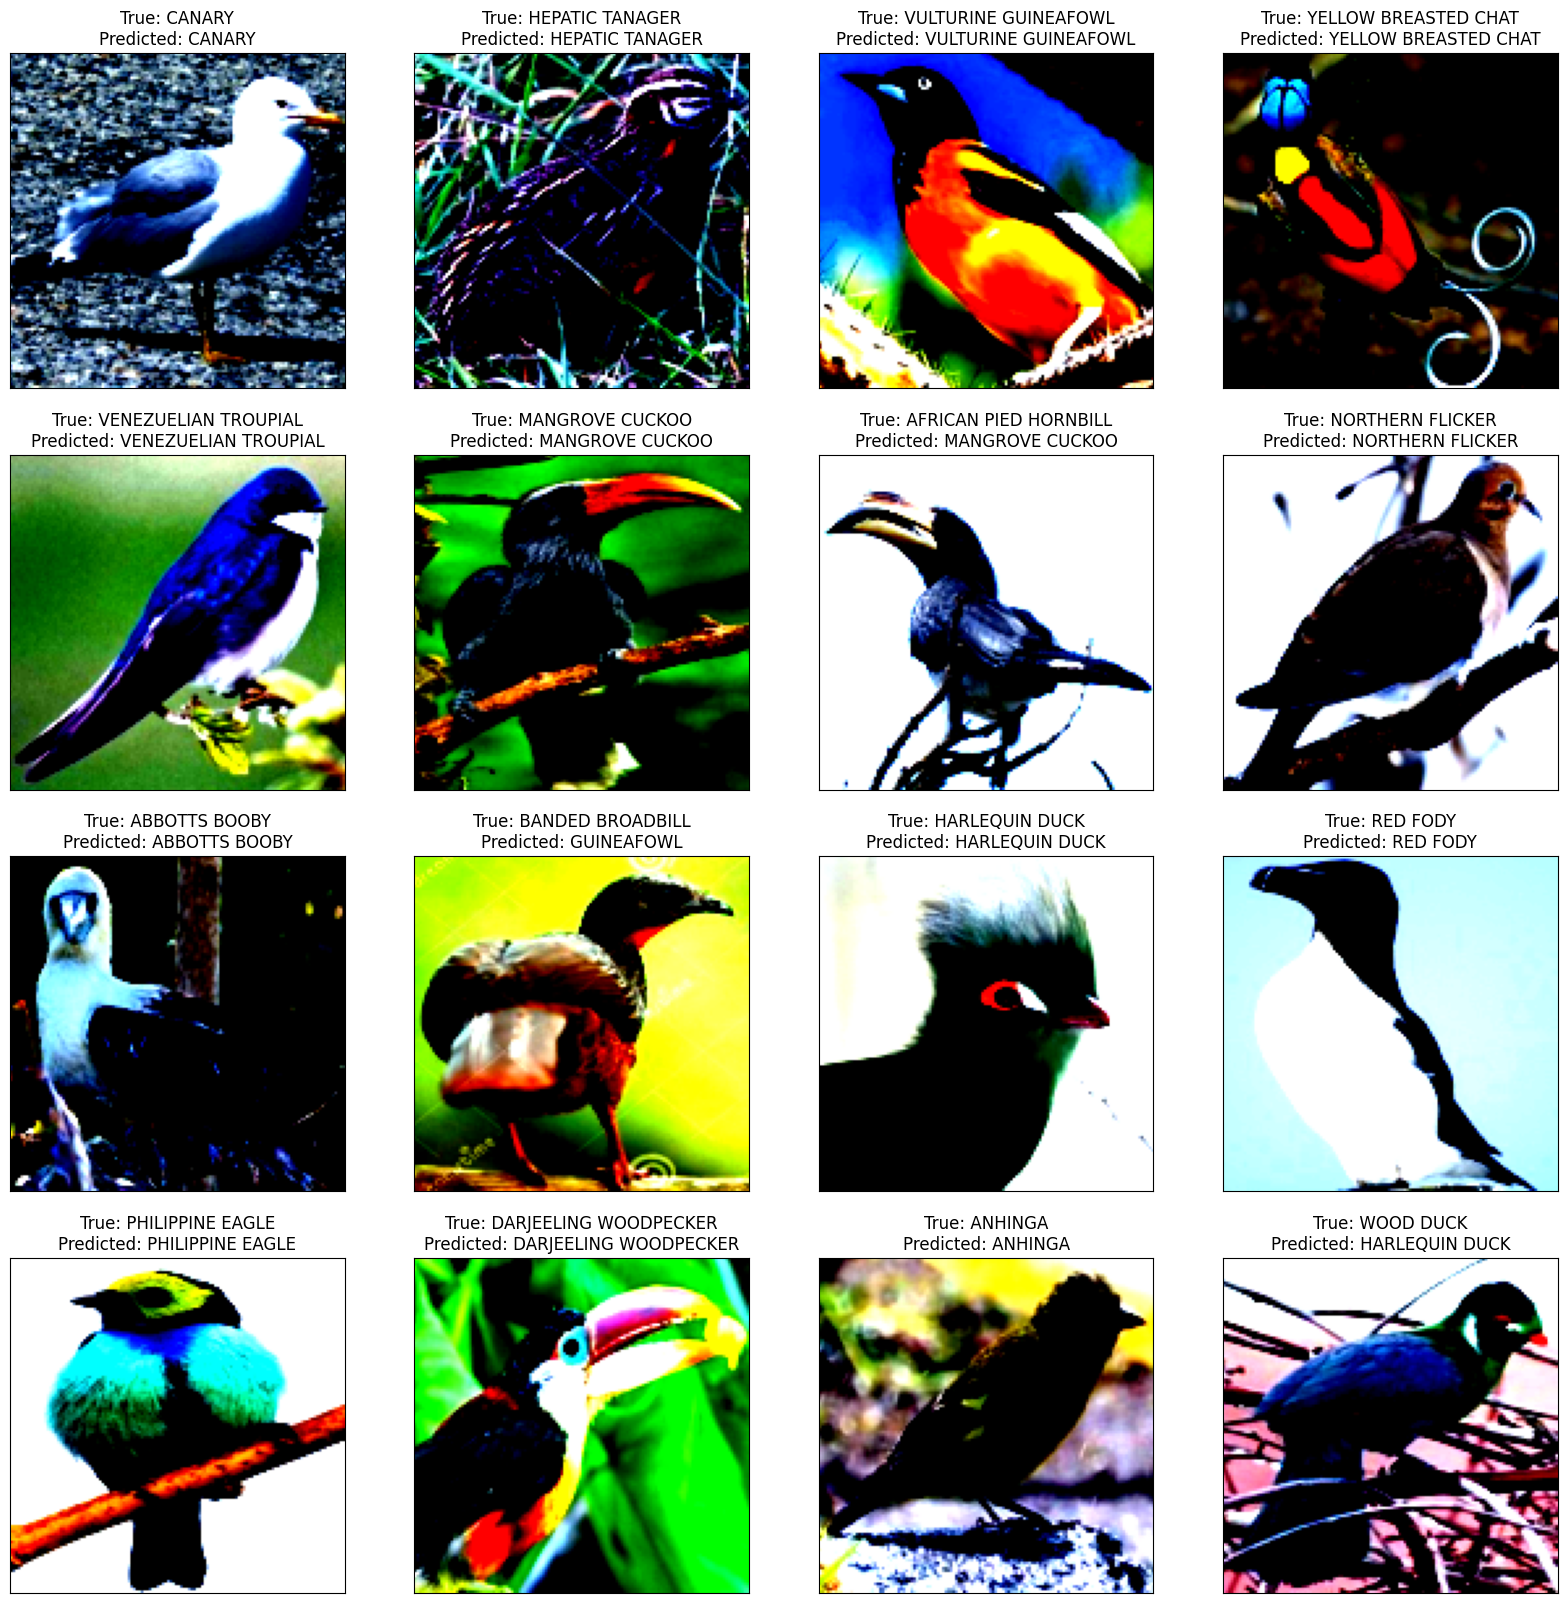

In [11]:
#view image, label, predicted label
dataiter=iter(test_dataloader)
images,labels=next(dataiter)
images=images.to(device)
labels=labels.to(device)

model.eval()
fig=plt.figure(figsize=(20,20))
with torch.no_grad():
    outputs=model(images)
    outputs=outputs.cpu().numpy()
    pred_labels=np.argmax(outputs,axis=1)
    for idx in np.arange(16):
        ax=fig.add_subplot(4,4,idx+1,xticks=[],yticks=[])
        image=images[idx]
        image=image.cpu().numpy()
        pred=pred_labels[idx]        
        plt.imshow(np.transpose(image,(1,2,0)))
        ax.set_title(f'True: {birds_list[labels[idx]]}\nPredicted: {birds_list[pred]}')

plt.show()        